In [1]:
import sourmash
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns

In [2]:
def read_fasta(file_path):
    """Generator function to read a FASTA file and yield header and sequence."""
    with open(file_path, 'r') as file:
        header, sequence = None, []
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if header:
                    yield header, ''.join(sequence)
                header, sequence = line, []
            else:
                sequence.append(line)
        if header:
            yield header, ''.join(sequence)

In [3]:
def extract_str_kmers_from_fasta(fasta_file, k=51, scale=1000):
    mh = sourmash.MinHash(n=0, scaled=scale, ksize=k, track_abundance=False)
    max_hash = int((2**64 - 1) / mh.scaled)
    passed_kmer = lambda kmer: mh.seq_to_hashes(kmer)[0] <= max_hash
    
    # boolean
    passed_kmers = []
    passed_kmers_strs = []
    
    kmers = {}
    for _, seq in read_fasta(fasta_file):
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            
            if passed_kmer(kmer):
                passed_kmers.append(i)
                passed_kmers_strs.append(kmer)
            
            if kmer in kmers:
                kmers[kmer].append(i)
            else:
                kmers[kmer] = [i]
    # return kmers, passed_kmers
    return passed_kmers, passed_kmers_strs

In [4]:
passed_kmers_pos, passed_kmers_str = extract_str_kmers_from_fasta("ecoli.fa", k=51, scale=10_000)

In [5]:
print(f"Number of passed k-mers: {len(passed_kmers_pos)}")

Number of passed k-mers: 438


In [6]:
genome_length = len(list(read_fasta("ecoli.fa"))[0][1])
print(genome_length)

4641652


In [12]:
def circular_plot(genome_length, kmer_positions, title="E. Coli Genome with K-mers selected at a scale of 10K"):
    sns.set_theme(style="white", context="paper", palette="deep")
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    fig.patch.set_facecolor('white')
    
    # Outer circle for the genome
    genome_circle = plt.Circle((0.5, 0.5), 1, transform=ax.transAxes, fill=False, color='dimgray', linewidth=2, alpha=0.8)
    ax.add_artist(genome_circle)
    
    # Convert k-mer positions to radians and draw them
    for pos in kmer_positions:
        angle = 2 * np.pi * pos / genome_length
        ax.plot([angle, angle], [0, 1], '-', color='darkblue', linewidth=2, alpha=0.8)
    
    # Annotations for base pair (bp) counts at 10 equidistant points starting at 0, rounding to nearest 'K' or 'M'
    for i in range(10):
        step = i * (genome_length / 10)
        angle = 2 * np.pi * step / genome_length
        if step == 0:
            label = "origin"
        elif step >= 1e6:
            label = f"{step/1e6:.1f}M bp"  # For values in millions, rounded to 1 decimal point
        else:
            label = f"{step/1000:.1f}K bp"  # For values in thousands, rounded to 1 decimal point
        # Adjust text rotation for perfect alignment
        text_alignment = 'right' if angle > np.pi/2 and angle < 3*np.pi/2 else 'left'
        ha = 'left' if angle < np.pi/2 or angle > 3*np.pi/2 else 'right'
        va = 'bottom' if angle == 0 else 'top' if angle == np.pi else 'center'
        rotation_adjustment = np.degrees(angle) + (90 if ha == 'left' else -90)
        
        ax.text(angle, 1.1, label, ha=ha, va=va, fontsize=9, rotation=rotation_adjustment, rotation_mode="anchor")
    
    # Customizations for a cleaner look
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    # plt.title(title, va='bottom', fontsize=14, fontweight='bold', color='black')
        
    plt.title(title + '\n\n', va='bottom', fontsize=14, fontweight='bold', color='black')

    
    
    
    plt.tight_layout()
    plt.savefig("circular_plot.png")
    
    plt.show()

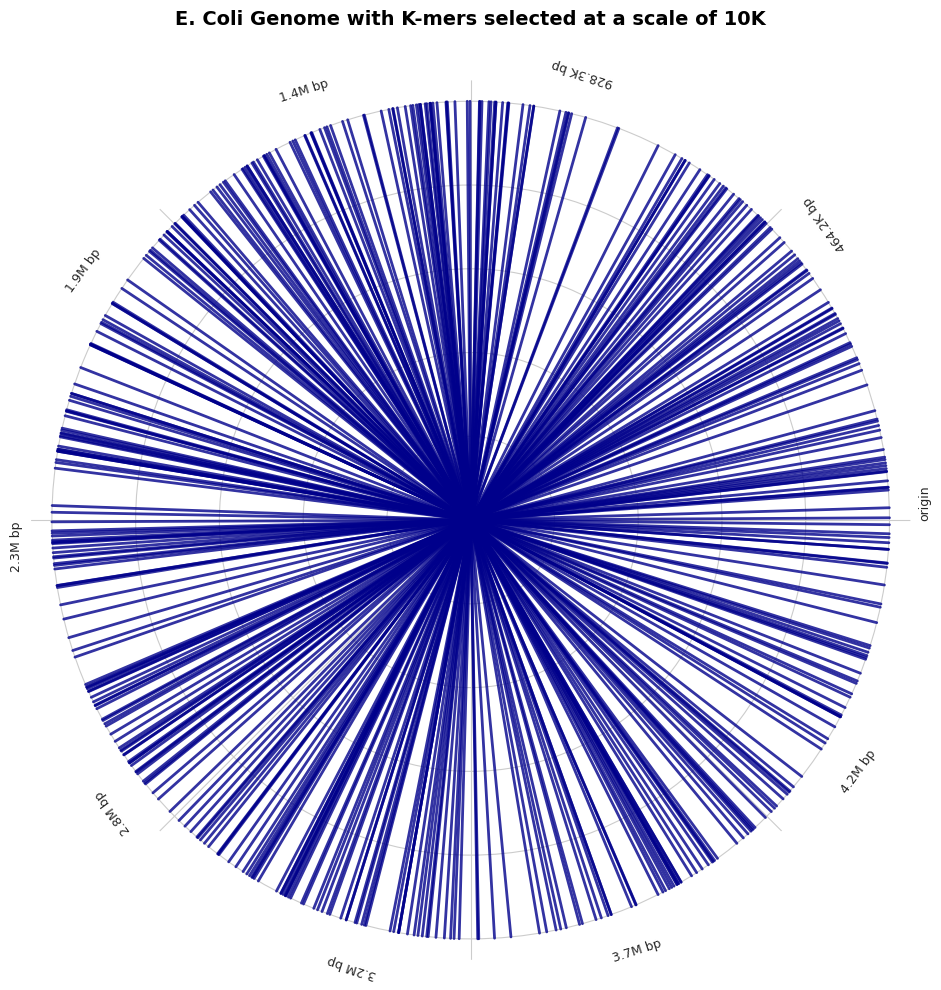

In [13]:
circular_plot(genome_length, passed_kmers_pos)